# Zoning lot construction using topology-based lot line classification

This notebook explores the use of a topology structure defined in postgis to obtain individual edges of a zoning lot and classify them as front, side or rear lot lines per definitions in the zoning resolution. Using a topology for this as opposed to discrete vector layers makes it easy to access properties of connected elements (i.e. names and widths of adjoining streets). These lot line flags can then also be used in turn to help classify faces of existing and proposed buildings, classify lots themselves as through/interior and corner and  

Imports and basic setup below:

In [4]:
import sys
import math
from OCC.Display.WebGl.jupyter_renderer import JupyterRenderer
from shapely.geometry import shape
from shapely.ops import transform
import shapely.wkt as wkt
import shapely.wkb as wkb
from psycopg2 import connect
from psycopg2.extras import DictCursor

In [6]:
# udtools core imports
module_path = '../python/'
if module_path not in sys.path:
    sys.path.append(module_path)
    
from connectors.postgis import prepare_parameterized_query_from_string
from geography.coordinate_systems import crs_wgs84, crs_webmercator, crs_nystateplane, wgs84_to_nystateplane, point_nycityhall_wgs84
from geography.coordinate_systems import test_studyarea_wgs84
# from geometry.common import coords_to_polygon, fuse_faces, multipolygon_to_faces, polyhedralsurfacez_to_brep, section_at, upgrade_brep, extrude_face
from models.existingbuilding import ExistingBuilding

ModuleNotFoundError: No module named 'generated'

Provide a bounding polygon to use as the Area of Interest (AOI), this is used to establish a local coordinate system for 3D geometry processing and rendering. The preset boundary here corresponds with the topology test area setup described in the topology setup outline from mid-April 2021.

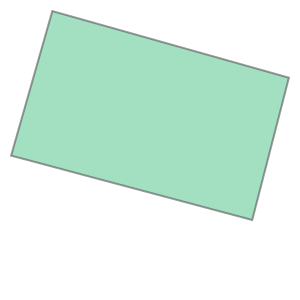

In [3]:
bounds_wkt = '''POLYGON ((1009405.90154069 234515.39897036, 1009930.58999844 234367.63467916, 1009849.1944143 234052.07026066, 1009314.48803851 234194.82559284, 1009405.90154069 234515.39897036))'''
aoi_bounds = wkt.loads(bounds_wkt)
aoi_bounds

Within that area, also provide a list of bbls to define the zoning lot.

In [4]:
bbl_array = ['2025770020', '2025770022']

First query gets the zoning lot boundary, defined as the union of one or more tax lots identified via a list of bbls, and also returns a list of existing building ids on all tax lots and edge ids from topology via spatial joins:

In [5]:
zoninglot_query = '''
SELECT
array_agg(DISTINCT b.bin) AS bins, -- building ids
array_agg(DISTINCT e.edge_id) as edges, -- lot edges from topo
ST_Translate(
  tl.geom,
  -{{ center_x }},
  -{{ center_y }}
) AS geom, -- zoning lot bounds as wkb in local coords
SUM(tl.area) as area
FROM
(
  select
  ST_Union(geom) as geom,
  SUM(ST_Area(geom)) as area
  from 
  public.taxlots
  where
  "BBL" in {{ bbl_array | inclause }}
) as tl
-- spatial join buildings
INNER JOIN public.buildings as b
on ST_Contains(
  tl.geom,
  ST_Centroid(
    ST_SetSRID(
      Box2D(b.geom)::geometry,
      2263
    )
  )
)
-- spatial join topo edges
INNER JOIN (
  select 
  *
  from
  topo_land.edge
) as e
ON ST_DWithin(
  ST_ExteriorRing(tl.geom), 
  ST_Centroid(e.geom),
  1.0
)
GROUP BY tl.geom
'''

Second query gets detailed information about lot edges, returning individual geometries, their azimuth, flag for front lot lines based on topological relationships, if true, the name and width of the street it fronts on.

In [6]:
lotedge_query = '''
SELECT
e.edge_id as id,
ST_Translate(
  e.geom,
  -{{ center_x }},
  -{{ center_y }}
) as geom,
ST_Azimuth(
  ST_LineInterpolatePoint(e.geom, 0.0),
  ST_LineInterpolatePoint(e.geom, 1.0)
) as azimuth,
coalesce(s.front, False) as front,
s.name,
s.width
FROM
topo_land.edge AS e
-- spatial join streets
LEFT OUTER JOIN (
  SELECT
  TRUE as front,
  (GetTopoGeomElements(topo))[1] AS face,
  *
  FROM
  public.streets
) AS s
ON s.face IN (e.left_face, e.right_face)
WHERE edge_id in {{ edge_array | inclause }}
;
'''

Now it's time to run the queries and set up a zoning lot. First, create a connection object using a connection string saved in a separate text file:

In [7]:
# make database connection
path_to_pg_key = "/Users/carsten/keys/pg-local-2"

with open(path_to_pg_key, "r") as keyreader:
    key = keyreader.read()
    conn = connect(key, cursor_factory=DictCursor)

In [8]:
aoi_bounds.wkb

b"\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x00\xc7\xbd\x96\xcd\xfb\xcd.AB_\x171\x9b\xa0\x0cA\x89F\x14.\x15\xd2.A\xdd\xaa\xd2\x13\xfd\x9b\x0cAiE\x8acr\xd1.A'\xd2\xe4\x8f \x92\x0cA\xff.\xe0\xf9D\xcd.A=k\xd0\x9a\x96\x96\x0cA\xc7\xbd\x96\xcd\xfb\xcd.AB_\x171\x9b\xa0\x0cA"

In [9]:
%%time
# make database query
zoninglot_params = {
  'center_x': aoi_bounds.representative_point().x,
  'center_y': aoi_bounds.representative_point().y,
  'aoi_bounds': aoi_bounds.wkb,
  'bbl_array': bbl_array
}

(pquery, bind_params) = prepare_parameterized_query_from_string(zoninglot_query, zoninglot_params)
cursor = conn.cursor()
cursor.execute(pquery, bind_params)
results = cursor.fetchall()
result = results [0] # should be a single result only

CPU times: user 4.33 ms, sys: 1.65 ms, total: 5.98 ms
Wall time: 3.77 s


In [10]:
# buildings on the zoning lot
result['bins']

[2003892, 2003893, 2109692, 2117467, 2117468]

In [11]:
result['edges']

[1491, 2701, 2702, 2703, 3984, 3988, 4717, 4719]

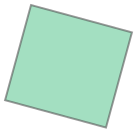

In [12]:
wkb.loads(result['geom'], hex=True)

In [13]:
# zoning lot edges
edge_array = result['edges']
edge_array

[1491, 2701, 2702, 2703, 3984, 3988, 4717, 4719]

In [14]:
# bldg ids
bldg_array = result['bins']
bldg_array

[2003892, 2003893, 2109692, 2117467, 2117468]

Now pass this list of lot edges to the second query.

In [15]:
%%time
# make database query
lotedge_params = {
  'center_x': aoi_bounds.representative_point().x,
  'center_y': aoi_bounds.representative_point().y,
  'edge_array': edge_array
}

(pquery, bind_params) = prepare_parameterized_query_from_string(lotedge_query, lotedge_params)
cursor = conn.cursor()
cursor.execute(pquery, bind_params)
results = cursor.fetchall()

CPU times: user 3.7 ms, sys: 1.95 ms, total: 5.65 ms
Wall time: 130 ms


In [16]:
# sketch of zoning lot edge results

# function to return true or false if azimuth a
# is within 45 degrees of all values in a list of azimuth b
def within_45_all(az_a, list_of_az_b):
  tests = []

  for az_b in list_of_az_b:
    # test uses modulo to ignore direction of azimuth
    az_a_ignoredir = az_a % math.pi
    az_b_ignoredir = az_b % math.pi
    test = (az_b_ignoredir - math.pi/4) <= az_a_ignoredir <= (az_b_ignoredir + math.pi/4)
    tests.append(test)
       
  return all(tests)

# dictionary to hold lot edges
lot_edges = {
  'front': [],
  'rear': [],
  'side': [],
}

# sort so front lot lines are first
results.sort(key=lambda i: i['front'], reverse=True)

# then assign to 
for edge in results:
  if edge['front']: lot_edges['front'].append(edge)
  elif within_45_all(edge['azimuth'], [e['azimuth'] for e in lot_edges['front']]): lot_edges['rear'].append(edge)
  else: lot_edges['side'].append(edge)
    
lot_edges

{'front': [[2701,
   '0102000020D708000002000000008098E59F1C47C000A061F9F9A137C00080985D4D9E4DC000685828C5D451C0',
   3.407966641746844,
   True,
   'Wales Avenue',
   Decimal('65')],
  [4719,
   '0102000020D70800000200000000809875038E40C000609EFE0A6E3840008098E59F1C47C000A061F9F9A137C0',
   3.4079642606599343,
   True,
   'Wales Avenue',
   Decimal('65')]],
 'rear': [[1491,
   '0102000020D708000002000000002066E36E4763C000A061E144B233C00020669EE31964C000D0B0505BE645C0',
   3.4079652785454204,
   False,
   None,
   None],
  [2702,
   '0102000020D708000002000000002066E36E4763C000A061E144B233C0002066BE7D7962C00000F3F4D11D0F40',
   0.2663768195460383,
   False,
   None,
   None],
  [3984,
   '0102000020D7080000020000000020660142A261C000609E2E448A3C40002066BE7D7962C00000F3F4D11D0F40',
   3.4079642843497595,
   False,
   None,
   None],
  [3988,
   '0102000020D708000002000000002066A2D6D560C000304FA3C9F949400020660142A261C000609E2E448A3C40',
   3.4079715080636213,
   False,
   None,
   None]]

## Next steps

Move the above functionality into the udtools core ZoningLot class. Use ZoningLot to get segmented facades for associated existingbuildings. DONE AS OF 2021-04-14

In [17]:
bldg_query = '''
SELECT
b.bin,
b.envelope_geom as envelope,
MAX(ST_Area(b.geom)) as footprint,
json_agg(
  json_build_object(
    'index', b.path[1],
    'geom', ST_AsBinary(b.geom),
    'lot_edge', e.edge_id,
    'wall', COALESCE(ST_Area(b.geom) < 1.0, false)
    -- possible/useful to also get azimuth?
  )
) as faces
FROM (
  select
  bin,
  geom as envelope_geom,
  (ST_Dump(geom)).* -- gives both path and geom
  from
  public.buildings
  where
  bin in (2003892, 2003893, 2109692, 2117467, 2117468)
) b-- building faces
LEFT OUTER JOIN (
  select * from topo_land.edge
  where edge_id in (1491, 2701, 2702, 2703, 3984, 3988, 4717, 4719)
) as e
ON ST_DWithin(
  e.geom,
  ST_Centroid(
  -- ST_ApproximateMedialAxis(
    b.geom
  ),
  3.0 -- 1ft tolerance to detect intersecting
)
GROUP BY b.bin, b.envelope_geom
;
'''

In [18]:
%%time
# make database query
bldg_params = {
  'center_x': aoi_bounds.representative_point().x,
  'center_y': aoi_bounds.representative_point().y,
  'bldg_array': bldg_array,
  'edge_array': edge_array
}

(pquery, bind_params) = prepare_parameterized_query_from_string(bldg_query, bldg_params)
cursor = conn.cursor()
cursor.execute(pquery, bind_params)
results = cursor.fetchall()

CPU times: user 2.12 ms, sys: 1.71 ms, total: 3.83 ms
Wall time: 111 ms


In [19]:
# results should have bin, envelope, footprint (area) 
# and faces (array of json objects)
results[0]['faces']

[{'index': 1,
  'geom': '\\x01eb030000010000000a000000001ca9c746cf2e410056d37a2e9a0c4100f0384547aa414080a9c5ff39cf2e4100ee6bb95b990c4100f0384547aa41408004232e35cf2e4100041a6660990c4100f0384547aa414000388e6332cf2e4100f0bb5e32990c4100f0384547aa4140803eae1b0bcf2e4100649b7b58990c4100f0384547aa4140800138b500cf2e4100701e9362990c4100f0384547aa41400076d69901cf2e41006ce74d71990c4100f0384547aa414080cda17f03cf2e41007acc9790990c4100f0384547aa41400041b04710cf2e4100ece35b639a0c4100f0384547aa4140001ca9c746cf2e410056d37a2e9a0c4100f0384547aa4140',
  'lot_edge': None,
  'wall': False},
 {'index': 13,
  'geom': '\\x01eb0300000100000005000000001ca9c746cf2e410056d37a2e9a0c4100f0384547aa414080a9c5ff39cf2e4100ee6bb95b990c4100f0384547aa414080a9c5ff39cf2e4100ee6bb95b990c41002ca913d0b45040001ca9c746cf2e410056d37a2e9a0c41002ca913d0b45040001ca9c746cf2e410056d37a2e9a0c4100f0384547aa4140',
  'lot_edge': None,
  'wall': True},
 {'index': 12,
  'geom': '\\x01eb030000010000000500000080a9c5ff39cf2e4100ee6bb95b990c4100f

In [20]:
# make existingbuilding from query
# brep_geom = polyhedralsurfacez_to_brep(row['geomwkt'])
# brep = brep_geom.Areas().First()
# b = ExistingBuilding(row['bin'], brep)
# bldgs[0].envelope